"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
from scipy.stats import beta

In [2]:
import sys                                                                       
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')  
from ephys_data import ephys_data
from visualize import gen_square_subplots, imshow, firing_overview,raster    

In [3]:
#data_dir = '/media/bigdata/Abuzar_Data/DS39_spont_taste_201029_154308'
data_dir = '/media/bigdata/Abuzar_Data/AM34/AM34_4Tastes_201215_115133/'
dat = ephys_data(data_dir)
dat.get_spikes()

In [4]:
spikes=dat.spikes[0]
time_lims = [2000,4000]
spikes = spikes[...,time_lims[0]:time_lims[1]]
print(spikes.shape)

(30, 40, 2000)


In [5]:
data_vec = spikes
bin_width = 50
data_vec_binned = np.sum(np.reshape(data_vec,(*data_vec.shape[:2],-1,bin_width)),axis=-1)
print(data_vec_binned.shape)

(30, 40, 40)


In [59]:
# # Some poisson spiking
length = data_vec_binned.shape[-1]
states = 3
trials = data_vec_binned.shape[0]
n_components = 3
neurons = data_vec_binned.shape[1]
fit = int(1e5)
samples = 2000
idx = np.arange(length)

# true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
# true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
# true_tau *= length
# true_tau = np.vectorize(np.int)(true_tau)

# #print(true_tau)

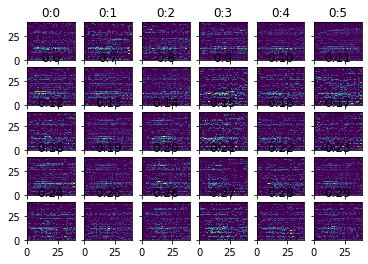

In [60]:
firing_overview(data_vec_binned,cmap='viridis');

In [61]:
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T
print(mean_vals.shape)

(40, 3)


In [62]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (trials,n_components))
    #w = pm.Dirichlet('w', a=np.ones(n_components)*5, shape = (trials,n_components))
    exp_rate = 1/10
    
    # Beta distributions of size "nrn"
    
    clust0_lambda = tt.stack([pm.Exponential('l00',exp_rate, shape = (neurons)),
                             pm.Exponential('l01',exp_rate, shape = (neurons)),
                             pm.Exponential('l02',exp_rate, shape = (neurons))])
    clust1_lambda = tt.stack([pm.Exponential('l10',exp_rate, shape = (neurons)),
                             pm.Exponential('l11',exp_rate, shape = (neurons)),
                             pm.Exponential('l12',exp_rate, shape = (neurons))])
    clust2_lambda = tt.stack([pm.Exponential('l20',exp_rate, shape = (neurons)),
                             pm.Exponential('l21',exp_rate, shape = (neurons)),
                             pm.Exponential('l22',exp_rate, shape = (neurons))])
    lambdas = tt.stack([clust0_lambda,clust1_lambda,clust2_lambda])
    
    #lambda0 = pm.Exponential('l00',alphas[0,0], betas[0,0])*w[0] + pm.Exponential('l10',alphas[1,0], betas[1,0])*w[1]
    #lambda1 = pm.Exponential('l01',alphas[0,1], betas[0,1])*w[0] + pm.Exponential('l11',alphas[1,1], betas[1,1])*w[1]
    #lambda2 = pm.Exponential('l02',alphas[0,2], betas[0,2])*w[0] + pm.Exponential('l12',alphas[1,2], betas[1,2])*w[1]
    #lambdas = tt.stack([lambda0,lambda1,lambda2])
    #components = [[pm.Beta.dist(alphas[comp,state], betas[comp,state]) for comp in range(comps)] for state in range(states)]
    #mixes = tt.stack([pm.Mixture(f'mixes{num}', w=w, comp_dists = this_comp, testval = mean_vals[num]) for num,this_comp in enumerate(components)])

In [63]:
print(w.tag.test_value.shape)
print(clust0_lambda.tag.test_value.shape)
print(clust1_lambda.tag.test_value.shape)
print(lambdas.tag.test_value.shape)

(30, 3)
(3, 40)
(3, 40)
(3, 3, 40)


In [64]:
with model:   
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [65]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trials,1,length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trials,1,length))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)[:,:,np.newaxis,:]

In [66]:
with model:
    selected_lambdas = tt.tensordot(w,lambdas,[1,0])[...,np.newaxis]
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)

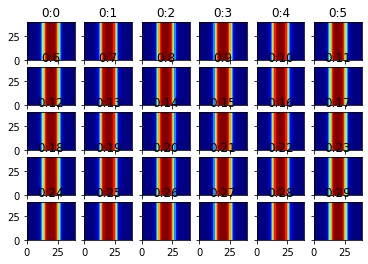

In [67]:
firing_overview(lambda_.tag.test_value);

In [68]:
with model:
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=data_vec_binned)

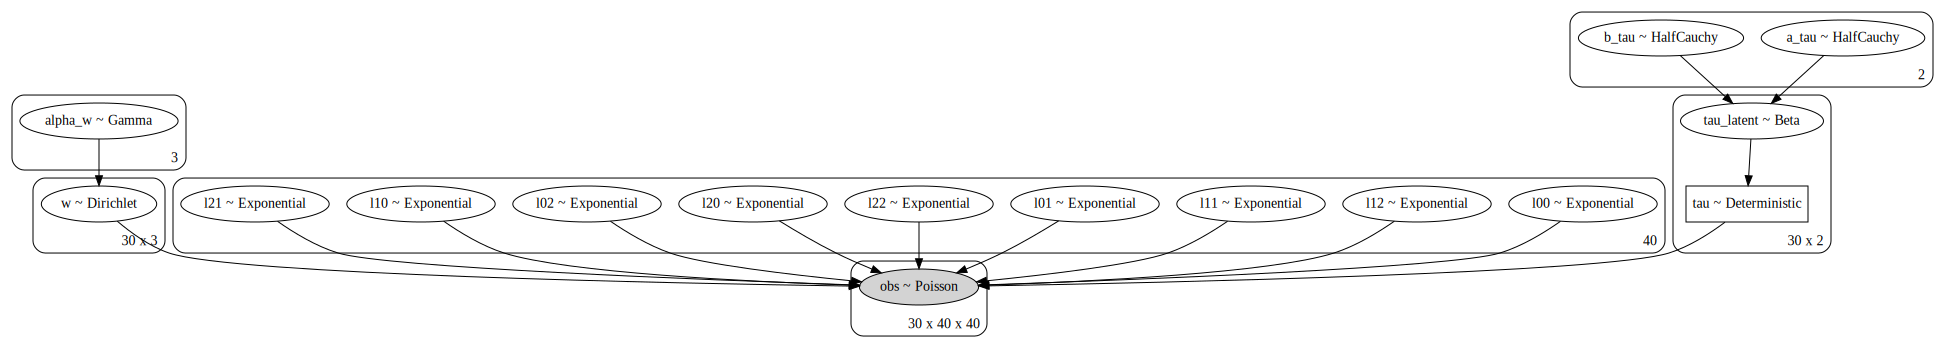

In [69]:
pm.model_to_graphviz(model)

In [70]:
# with model:     
#     step = pm.Metropolis()
#     #step = pm.NUTS()
#     trace = pm.sample(4000, tune=1000, 
#                   step = step,
#                   chains = 12, cores = 12)
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)


  0%|          | 0/100000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])

Average Loss = 3.6503e+05:   0%|          | 396/100000 [00:01<05:17, 313.73it/s]


Average Loss = 3.4325e+05:   1%|          | 812/100000 [00:02<05:00, 330.08it/s]


Average Loss = 3.1013e+05:   1%|          | 1232/100000 [00:03<05:51, 280.96it/s]


Average Loss = 2.716e+05:   2%|▏         | 1647/100000 [00:05<05:34, 293.93it/s] 


Average Loss = 2.3844e+05:   2%|▏         | 2053/100000 [00:06<05:48, 281.22it/s]


Average Loss = 2.1003e+05:   2%|▏         | 2465/100000 [00:08<06:07, 265.59it/s]


Average Loss = 1.8482e+05:   3%|▎         | 2880/100000 [00:09<05:10, 313.27it/s]


Average Loss = 1.634e+05:   3%|▎         | 3330/100000 [00:10<05:11, 309.96it/s]


Average Loss = 1.4427e+05:   4%|▎         | 3713/100000 [00:12<05:03, 317.17it/s]


Average Loss = 1.2762e+05:   4%|▍         | 4138/100000 [00:13<05:37, 284.44it/s]


Average Loss = 1.1345e+05:   5%|▍         | 4577/100000 [00:14<04:54, 324.46it/s]


Average Loss = 1.0096e+05:   5%|▍         | 4994/100000 [00:16<05:12, 303.68it/s]


Average Loss = 89,836:   5%|▌         | 5420/100000 [00:17<04:30, 349.49it/s]


Average Loss = 80,322:   6%|▌         | 5839/100000 [00:18<05:11, 302.54it/s]


Average Loss = 72,311:   6%|▋         | 6314/100000 [00:20<04:28, 348.74it/s]


Average Loss = 65,342:   7%|▋         | 6748/100000 [00:21<04:21, 356.30it/s]


Average Loss = 59,745:   7%|▋         | 7189/100000 [00:22<04:41, 329.26it/s]


Average Loss = 54,987:   8%|▊         | 7613/100000 [00:23<04:29, 342.48it/s]


Average Loss = 51,184:   8%|▊         | 8090/100000 [00:25<04:20, 353.29it/s]


Average Loss = 48,011:   9%|▊         | 8509/100000 [00:26<04:57, 307.15it/s]


Average Loss = 45,391:   9%|▉         | 8951/100000 [00:27<04:13, 358.96it/s]


Average Loss = 43,322:   9%|▉         | 9385/100000 [00:29<04:12, 359.36it/s]


Average Loss = 41,649:  10%|▉         | 9840/100000 [00:30<05:21, 280.43it/s]


Average Loss = 40,334:  10%|█         | 10286/100000 [00:31<04:38, 321.63it/s]


Average Loss = 39,259:  11%|█         | 10702/100000 [00:33<05:03, 293.97it/s]


Average Loss = 38,431:  11%|█         | 11148/100000 [00:34<04:48, 307.70it/s]


Average Loss = 37,748:  12%|█▏        | 11580/100000 [00:36<05:25, 271.91it/s]


Average Loss = 37,195:  12%|█▏        | 12001/100000 [00:37<04:44, 309.65it/s]


Average Loss = 36,747:  12%|█▏        | 12433/100000 [00:38<04:49, 302.56it/s]


Average Loss = 36,388:  13%|█▎        | 12871/100000 [00:40<04:31, 320.70it/s]


Average Loss = 36,108:  13%|█▎        | 13310/100000 [00:41<04:52, 296.54it/s]


Average Loss = 35,878:  14%|█▎        | 13714/100000 [00:43<04:46, 301.40it/s]


Average Loss = 35,693:  14%|█▍        | 14151/100000 [00:44<04:29, 318.93it/s]


Average Loss = 35,541:  15%|█▍        | 14589/100000 [00:45<04:26, 320.99it/s]


Average Loss = 35,424:  15%|█▌        | 15017/100000 [00:47<05:02, 281.21it/s]


Average Loss = 35,327:  15%|█▌        | 15425/100000 [00:49<04:22, 322.60it/s]


Average Loss = 35,249:  16%|█▌        | 15850/100000 [00:50<06:00, 233.19it/s]


Average Loss = 35,187:  16%|█▋        | 16280/100000 [00:52<05:05, 273.73it/s]


Average Loss = 35,136:  17%|█▋        | 16671/100000 [00:53<05:11, 267.55it/s]


Average Loss = 35,095:  17%|█▋        | 17121/100000 [00:55<04:34, 301.75it/s]


Average Loss = 35,061:  18%|█▊        | 17533/100000 [00:56<05:03, 272.02it/s]


Average Loss = 35,033:  18%|█▊        | 17979/100000 [00:58<05:14, 260.89it/s]


Average Loss = 35,009:  18%|█▊        | 18394/100000 [00:59<04:09, 327.49it/s]


Average Loss = 34,987:  19%|█▉        | 18812/100000 [01:01<03:59, 338.48it/s]


Average Loss = 34,965:  19%|█▉        | 19272/100000 [01:02<03:56, 341.56it/s]


Average Loss = 34,943:  20%|█▉        | 19675/100000 [01:03<04:05, 327.01it/s]


Average Loss = 34,918:  20%|██        | 20123/100000 [01:05<04:01, 330.70it/s]


Average Loss = 34,892:  21%|██        | 20565/100000 [01:06<04:08, 319.52it/s]


Average Loss = 34,862:  21%|██        | 20993/100000 [01:07<03:42, 354.60it/s]


Average Loss = 34,832:  21%|██▏       | 21429/100000 [01:08<03:43, 352.27it/s]


Average Loss = 34,803:  22%|██▏       | 21863/100000 [01:10<03:40, 354.07it/s]


Average Loss = 34,775:  22%|██▏       | 22295/100000 [01:11<04:19, 299.39it/s]


Average Loss = 34,748:  23%|██▎       | 22730/100000 [01:12<04:40, 275.80it/s]


Average Loss = 34,726:  23%|██▎       | 23148/100000 [01:14<04:02, 317.10it/s]


Average Loss = 34,706:  24%|██▎       | 23602/100000 [01:15<03:41, 345.19it/s]


Average Loss = 34,686:  24%|██▍       | 24028/100000 [01:16<03:51, 327.57it/s]


Average Loss = 34,668:  24%|██▍       | 24463/100000 [01:18<03:32, 356.00it/s]


Average Loss = 34,651:  25%|██▍       | 24877/100000 [01:19<03:55, 318.58it/s]


Average Loss = 34,635:  25%|██▌       | 25332/100000 [01:20<03:42, 335.12it/s]


Average Loss = 34,620:  26%|██▌       | 25749/100000 [01:22<03:55, 314.73it/s]


Average Loss = 34,603:  26%|██▌       | 26189/100000 [01:23<03:55, 314.00it/s]


Average Loss = 34,586:  27%|██▋       | 26618/100000 [01:24<04:08, 295.00it/s]


Average Loss = 34,570:  27%|██▋       | 27057/100000 [01:26<04:12, 288.69it/s]


Average Loss = 34,552:  27%|██▋       | 27490/100000 [01:27<03:23, 355.71it/s]


Average Loss = 34,535:  28%|██▊       | 27916/100000 [01:28<04:04, 294.26it/s]


Average Loss = 34,519:  28%|██▊       | 28353/100000 [01:30<03:45, 318.09it/s]


Average Loss = 34,504:  29%|██▉       | 28761/100000 [01:31<03:33, 333.67it/s]


Average Loss = 34,491:  29%|██▉       | 29184/100000 [01:32<03:20, 353.77it/s]


Average Loss = 34,478:  30%|██▉       | 29644/100000 [01:34<03:49, 307.14it/s]


Average Loss = 34,465:  30%|███       | 30089/100000 [01:35<03:32, 328.86it/s]


Average Loss = 34,455:  31%|███       | 30507/100000 [01:36<03:23, 341.66it/s]


Average Loss = 34,447:  31%|███       | 30942/100000 [01:37<03:12, 358.50it/s]


Average Loss = 34,439:  31%|███▏      | 31378/100000 [01:39<03:20, 342.92it/s]


Average Loss = 34,432:  32%|███▏      | 31814/100000 [01:40<03:12, 354.95it/s]


Average Loss = 34,426:  32%|███▏      | 32238/100000 [01:41<04:09, 271.44it/s]


Average Loss = 34,419:  33%|███▎      | 32675/100000 [01:43<03:23, 331.58it/s]


Average Loss = 34,413:  33%|███▎      | 33092/100000 [01:44<03:36, 309.42it/s]


Average Loss = 34,408:  34%|███▎      | 33533/100000 [01:46<03:31, 314.01it/s]


Average Loss = 34,402:  34%|███▍      | 33951/100000 [01:47<03:08, 350.26it/s]


Average Loss = 34,398:  34%|███▍      | 34387/100000 [01:48<03:04, 355.85it/s]


Average Loss = 34,393:  35%|███▍      | 34821/100000 [01:49<03:03, 354.65it/s]


Average Loss = 34,389:  35%|███▌      | 35256/100000 [01:51<04:07, 261.50it/s]


Average Loss = 34,385:  36%|███▌      | 35696/100000 [01:52<03:58, 270.06it/s]


Average Loss = 34,381:  36%|███▌      | 36106/100000 [01:54<04:22, 243.76it/s]


Average Loss = 34,378:  37%|███▋      | 36519/100000 [01:56<04:03, 261.18it/s]


Average Loss = 34,375:  37%|███▋      | 36951/100000 [01:57<03:40, 285.76it/s]


Average Loss = 34,373:  37%|███▋      | 37366/100000 [01:59<03:23, 307.86it/s]


Average Loss = 34,370:  38%|███▊      | 37809/100000 [02:00<03:56, 263.16it/s]


Average Loss = 34,366:  38%|███▊      | 38238/100000 [02:02<03:21, 306.96it/s]


Average Loss = 34,364:  39%|███▊      | 38637/100000 [02:03<03:55, 261.11it/s]


Average Loss = 34,361:  39%|███▉      | 39080/100000 [02:05<03:13, 315.23it/s]


Average Loss = 34,359:  40%|███▉      | 39519/100000 [02:06<03:41, 273.04it/s]


Average Loss = 34,357:  40%|███▉      | 39927/100000 [02:08<03:01, 331.29it/s]


Average Loss = 34,354:  40%|████      | 40348/100000 [02:09<03:48, 261.03it/s]


Average Loss = 34,352:  41%|████      | 40769/100000 [02:11<02:59, 330.67it/s]


Average Loss = 34,350:  41%|████      | 41209/100000 [02:12<02:42, 361.05it/s]


Average Loss = 34,348:  42%|████▏     | 41640/100000 [02:13<02:50, 342.68it/s]


Average Loss = 34,347:  42%|████▏     | 42072/100000 [02:14<03:11, 302.11it/s]


Average Loss = 34,344:  43%|████▎     | 42501/100000 [02:16<04:05, 234.00it/s]


Average Loss = 34,341:  43%|████▎     | 42915/100000 [02:17<03:03, 310.49it/s]


Average Loss = 34,338:  43%|████▎     | 43367/100000 [02:19<03:11, 295.65it/s]


Average Loss = 34,336:  44%|████▍     | 43769/100000 [02:21<03:40, 255.46it/s]


Average Loss = 34,334:  44%|████▍     | 44193/100000 [02:22<03:02, 305.20it/s]


Average Loss = 34,333:  45%|████▍     | 44639/100000 [02:24<03:45, 245.54it/s]


Average Loss = 34,331:  45%|████▌     | 45031/100000 [02:25<03:25, 267.71it/s]


Average Loss = 34,330:  45%|████▌     | 45476/100000 [02:27<02:42, 335.58it/s]


Average Loss = 34,328:  46%|████▌     | 45897/100000 [02:28<02:42, 333.63it/s]


Average Loss = 34,326:  46%|████▋     | 46327/100000 [02:29<02:45, 324.35it/s]


Average Loss = 34,324:  47%|████▋     | 46759/100000 [02:31<03:23, 261.24it/s]


Average Loss = 34,322:  47%|████▋     | 47165/100000 [02:33<03:20, 263.38it/s]


Average Loss = 34,319:  48%|████▊     | 47624/100000 [02:34<03:03, 284.94it/s]


Average Loss = 34,318:  48%|████▊     | 48035/100000 [02:35<02:54, 297.07it/s]


Average Loss = 34,315:  48%|████▊     | 48471/100000 [02:37<03:12, 267.73it/s]


Average Loss = 34,313:  49%|████▉     | 48910/100000 [02:38<03:10, 268.30it/s]


Average Loss = 34,310:  49%|████▉     | 49338/100000 [02:40<02:35, 325.25it/s]


Average Loss = 34,308:  50%|████▉     | 49766/100000 [02:41<03:23, 246.79it/s]


Average Loss = 34,306:  50%|█████     | 50192/100000 [02:43<02:27, 338.33it/s]


Average Loss = 34,303:  51%|█████     | 50618/100000 [02:44<02:23, 344.43it/s]


Average Loss = 34,301:  51%|█████     | 51049/100000 [02:45<02:33, 319.83it/s]


Average Loss = 34,299:  51%|█████▏    | 51471/100000 [02:47<02:39, 305.03it/s]


Average Loss = 34,296:  52%|█████▏    | 51924/100000 [02:48<02:49, 284.23it/s]


Average Loss = 34,293:  52%|█████▏    | 52347/100000 [02:49<02:20, 339.91it/s]


Average Loss = 34,290:  53%|█████▎    | 52786/100000 [02:51<02:41, 292.54it/s]


Average Loss = 34,289:  53%|█████▎    | 53207/100000 [02:52<02:19, 336.44it/s]


Average Loss = 34,286:  54%|█████▎    | 53640/100000 [02:53<02:10, 355.19it/s]


Average Loss = 34,283:  54%|█████▍    | 54071/100000 [02:54<02:12, 345.56it/s]


Average Loss = 34,279:  55%|█████▍    | 54530/100000 [02:56<02:09, 351.26it/s]


Average Loss = 34,276:  55%|█████▍    | 54947/100000 [02:57<02:12, 339.78it/s]


Average Loss = 34,274:  55%|█████▌    | 55379/100000 [02:59<02:49, 263.50it/s]


Average Loss = 34,271:  56%|█████▌    | 55788/100000 [03:00<02:10, 339.29it/s]


Average Loss = 34,269:  56%|█████▌    | 56207/100000 [03:01<02:38, 275.90it/s]


Average Loss = 34,268:  57%|█████▋    | 56643/100000 [03:03<02:16, 316.92it/s]


Average Loss = 34,266:  57%|█████▋    | 57095/100000 [03:04<02:35, 276.06it/s]


Average Loss = 34,263:  58%|█████▊    | 57512/100000 [03:06<02:03, 344.47it/s]


Average Loss = 34,260:  58%|█████▊    | 57957/100000 [03:07<02:29, 281.66it/s]


Average Loss = 34,258:  58%|█████▊    | 58376/100000 [03:08<02:04, 333.92it/s]


Average Loss = 34,256:  59%|█████▉    | 58808/100000 [03:10<01:57, 351.97it/s]


Average Loss = 34,254:  59%|█████▉    | 59253/100000 [03:11<02:08, 316.26it/s]


Average Loss = 34,251:  60%|█████▉    | 59666/100000 [03:13<02:12, 304.03it/s]


Average Loss = 34,249:  60%|██████    | 60109/100000 [03:14<02:01, 329.36it/s]


Average Loss = 34,246:  61%|██████    | 60537/100000 [03:15<02:24, 273.80it/s]


Average Loss = 34,244:  61%|██████    | 60957/100000 [03:16<01:49, 356.89it/s]


Average Loss = 34,242:  61%|██████▏   | 61390/100000 [03:18<02:07, 303.45it/s]


Average Loss = 34,240:  62%|██████▏   | 61822/100000 [03:19<01:47, 354.89it/s]


Average Loss = 34,239:  62%|██████▏   | 62259/100000 [03:20<01:47, 350.40it/s]


Average Loss = 34,237:  63%|██████▎   | 62693/100000 [03:22<01:48, 343.62it/s]


Average Loss = 34,234:  63%|██████▎   | 63135/100000 [03:23<01:51, 330.39it/s]


Average Loss = 34,232:  64%|██████▎   | 63558/100000 [03:24<01:44, 348.82it/s]


Average Loss = 34,231:  64%|██████▍   | 64010/100000 [03:26<02:17, 261.01it/s]


Average Loss = 34,229:  64%|██████▍   | 64424/100000 [03:27<01:52, 317.35it/s]


Average Loss = 34,226:  65%|██████▍   | 64851/100000 [03:28<01:46, 329.72it/s]


Average Loss = 34,224:  65%|██████▌   | 65282/100000 [03:30<01:43, 335.11it/s]


Average Loss = 34,223:  66%|██████▌   | 65708/100000 [03:31<01:46, 321.89it/s]


Average Loss = 34,220:  66%|██████▌   | 66164/100000 [03:33<02:01, 278.35it/s]


Average Loss = 34,220:  67%|██████▋   | 66580/100000 [03:34<02:15, 246.78it/s]


Average Loss = 34,219:  67%|██████▋   | 66991/100000 [03:36<01:43, 318.86it/s]


Average Loss = 34,216:  67%|██████▋   | 67441/100000 [03:37<01:43, 315.22it/s]


Average Loss = 34,214:  68%|██████▊   | 67862/100000 [03:38<01:53, 282.94it/s]


Average Loss = 34,212:  68%|██████▊   | 68306/100000 [03:40<01:38, 323.06it/s]


Average Loss = 34,210:  69%|██████▊   | 68723/100000 [03:41<01:33, 334.47it/s]


Average Loss = 34,208:  69%|██████▉   | 69154/100000 [03:43<01:54, 270.02it/s]


Average Loss = 34,205:  70%|██████▉   | 69595/100000 [03:44<01:43, 295.10it/s]


Average Loss = 34,203:  70%|███████   | 70008/100000 [03:46<01:34, 317.40it/s]


Average Loss = 34,201:  70%|███████   | 70458/100000 [03:47<01:32, 317.90it/s]


Average Loss = 34,199:  71%|███████   | 70873/100000 [03:48<01:30, 322.06it/s]


Average Loss = 34,197:  71%|███████▏  | 71319/100000 [03:50<01:32, 309.03it/s]


Average Loss = 34,196:  72%|███████▏  | 71737/100000 [03:51<01:25, 329.54it/s]


Average Loss = 34,193:  72%|███████▏  | 72183/100000 [03:52<01:23, 332.09it/s]


Average Loss = 34,189:  73%|███████▎  | 72615/100000 [03:54<01:20, 341.57it/s]


Average Loss = 34,188:  73%|███████▎  | 73037/100000 [03:55<01:18, 342.31it/s]


Average Loss = 34,187:  73%|███████▎  | 73480/100000 [03:56<01:24, 313.87it/s]


Average Loss = 34,185:  74%|███████▍  | 73898/100000 [03:58<01:17, 336.84it/s]


Average Loss = 34,182:  74%|███████▍  | 74350/100000 [03:59<01:34, 270.52it/s]


Average Loss = 34,180:  75%|███████▍  | 74761/100000 [04:01<01:26, 290.87it/s]


Average Loss = 34,177:  75%|███████▌  | 75189/100000 [04:02<01:32, 268.64it/s]


Average Loss = 34,175:  76%|███████▌  | 75624/100000 [04:04<01:30, 269.09it/s]


Average Loss = 34,173:  76%|███████▌  | 76056/100000 [04:05<01:13, 325.67it/s]


Average Loss = 34,171:  76%|███████▋  | 76479/100000 [04:06<01:29, 262.98it/s]


Average Loss = 34,169:  77%|███████▋  | 76892/100000 [04:08<01:12, 319.84it/s]


Average Loss = 34,166:  77%|███████▋  | 77345/100000 [04:09<01:12, 311.90it/s]


Average Loss = 34,163:  78%|███████▊  | 77771/100000 [04:10<01:07, 328.73it/s]


Average Loss = 34,160:  78%|███████▊  | 78208/100000 [04:11<01:01, 354.83it/s]


Average Loss = 34,157:  79%|███████▊  | 78645/100000 [04:13<01:00, 350.42it/s]


Average Loss = 34,155:  79%|███████▉  | 79066/100000 [04:14<01:02, 333.34it/s]


Average Loss = 34,153:  80%|███████▉  | 79503/100000 [04:15<01:12, 283.10it/s]


Average Loss = 34,151:  80%|███████▉  | 79932/100000 [04:17<00:57, 352.04it/s]


Average Loss = 34,149:  80%|████████  | 80369/100000 [04:18<00:57, 339.12it/s]


Average Loss = 34,147:  81%|████████  | 80787/100000 [04:20<01:02, 306.44it/s]


Average Loss = 34,144:  81%|████████  | 81244/100000 [04:21<00:55, 340.58it/s]


Average Loss = 34,141:  82%|████████▏ | 81664/100000 [04:22<00:53, 339.78it/s]


Average Loss = 34,137:  82%|████████▏ | 82094/100000 [04:24<00:53, 337.74it/s]


Average Loss = 34,133:  83%|████████▎ | 82522/100000 [04:25<00:53, 325.69it/s]


Average Loss = 34,130:  83%|████████▎ | 82947/100000 [04:26<00:58, 290.01it/s]


Average Loss = 34,129:  83%|████████▎ | 83391/100000 [04:28<00:51, 321.01it/s]


Average Loss = 34,127:  84%|████████▍ | 83811/100000 [04:29<00:54, 295.01it/s]


Average Loss = 34,124:  84%|████████▍ | 84271/100000 [04:30<00:47, 328.77it/s]


Average Loss = 34,122:  85%|████████▍ | 84680/100000 [04:32<00:53, 284.85it/s]


Average Loss = 34,120:  85%|████████▌ | 85112/100000 [04:33<00:43, 344.21it/s]


Average Loss = 34,117:  86%|████████▌ | 85576/100000 [04:34<00:42, 342.87it/s]


Average Loss = 34,114:  86%|████████▌ | 85983/100000 [04:36<00:45, 309.09it/s]


Average Loss = 34,110:  86%|████████▋ | 86410/100000 [04:37<00:39, 347.93it/s]


Average Loss = 34,107:  87%|████████▋ | 86872/100000 [04:38<00:37, 352.49it/s]


Average Loss = 34,103:  87%|████████▋ | 87306/100000 [04:39<00:36, 351.93it/s]


Average Loss = 34,101:  88%|████████▊ | 87733/100000 [04:41<00:35, 341.22it/s]


Average Loss = 34,098:  88%|████████▊ | 88147/100000 [04:42<00:36, 326.13it/s]


Average Loss = 34,096:  89%|████████▊ | 88603/100000 [04:43<00:32, 350.15it/s]


Average Loss = 34,092:  89%|████████▉ | 89024/100000 [04:45<00:32, 334.21it/s]


Average Loss = 34,090:  89%|████████▉ | 89454/100000 [04:46<00:33, 317.95it/s]


Average Loss = 34,087:  90%|████████▉ | 89903/100000 [04:47<00:30, 330.72it/s]


Average Loss = 34,084:  90%|█████████ | 90331/100000 [04:49<00:27, 351.19it/s]


Average Loss = 34,082:  91%|█████████ | 90769/100000 [04:50<00:33, 271.75it/s]


Average Loss = 34,079:  91%|█████████ | 91169/100000 [04:52<00:28, 310.18it/s]


Average Loss = 34,076:  92%|█████████▏| 91626/100000 [04:53<00:23, 349.53it/s]


Average Loss = 34,073:  92%|█████████▏| 92061/100000 [04:54<00:23, 338.83it/s]


Average Loss = 34,070:  92%|█████████▏| 92477/100000 [04:55<00:23, 319.67it/s]


Average Loss = 34,066:  93%|█████████▎| 92928/100000 [04:57<00:20, 340.05it/s]


Average Loss = 34,063:  93%|█████████▎| 93361/100000 [04:58<00:18, 359.35it/s]


Average Loss = 34,061:  94%|█████████▍| 93793/100000 [04:59<00:17, 346.55it/s]


Average Loss = 34,058:  94%|█████████▍| 94227/100000 [05:01<00:20, 280.62it/s]


Average Loss = 34,055:  95%|█████████▍| 94646/100000 [05:02<00:16, 315.31it/s]


Average Loss = 34,053:  95%|█████████▌| 95072/100000 [05:03<00:15, 315.00it/s]


Average Loss = 34,050:  96%|█████████▌| 95532/100000 [05:05<00:15, 281.69it/s]


Average Loss = 34,048:  96%|█████████▌| 95943/100000 [05:06<00:13, 305.57it/s]


Average Loss = 34,047:  96%|█████████▋| 96382/100000 [05:07<00:13, 271.18it/s]


Average Loss = 34,044:  97%|█████████▋| 96797/100000 [05:09<00:09, 330.50it/s]


Average Loss = 34,040:  97%|█████████▋| 97248/100000 [05:10<00:07, 351.31it/s]


Average Loss = 34,036:  98%|█████████▊| 97672/100000 [05:11<00:06, 343.83it/s]


Average Loss = 34,032:  98%|█████████▊| 98121/100000 [05:13<00:06, 298.44it/s]


Average Loss = 34,030:  99%|█████████▊| 98548/100000 [05:14<00:05, 285.69it/s]


Average Loss = 34,028:  99%|█████████▉| 98971/100000 [05:15<00:02, 352.26it/s]


Average Loss = 34,027:  99%|█████████▉| 99421/100000 [05:17<00:01, 342.28it/s]


Average Loss = 34,025: 100%|█████████▉| 99845/100000 [05:18<00:00, 330.03it/s]


Average Loss = 34,024: 100%|██████████| 100000/100000 [05:18<00:00, 313.63it/s][A
Finished [100%]: Average Loss = 34,024


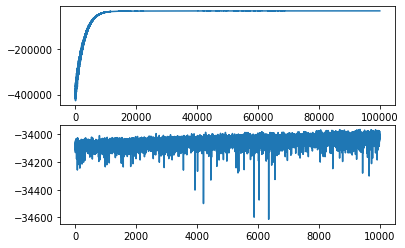

In [71]:
#pm.traceplot(trace);
fig,ax = plt.subplots(2,1)
ax[0].plot(-inference.hist)
len_hist = len(-inference.hist)
ax[1].plot(-inference.hist[int(0.9*len_hist):])

In [72]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)


100%|██████████| 2000/2000 [00:09<00:00, 221.12it/s]


In [73]:
print(ppc_trace['obs'].shape)
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

(2000, 30, 40, 40)


In [74]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
print(int_tau.shape)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
print(mode_tau.shape)

(2000, 30, 2)
(30, 2)


In [75]:
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [76]:
# cat_samples = trace['category']
# plt.imshow(cat_samples,aspect='auto')
# print(cat_samples.shape)
w_samples = trace['w']
w_samples_long = np.reshape(w_samples,(-1,w_samples.shape[-1]))
print(w_samples_long.shape)
print(w_samples.shape)
mean_w = np.mean(w_samples,axis=0)
std_w = np.mean(w_samples,axis=0)
categorical_w = np.argmax(mean_w,axis=-1)
print(categorical_w.shape)

(60000, 3)
(2000, 30, 3)
(30,)


In [77]:
hist_bins = np.linspace(0,1,20)
w_hists = np.array([np.histogram(x,hist_bins)[0] for x in w_samples.swapaxes(0,1)[...,0]])

In [78]:
trial_count = 5
selected_trials = np.random.choice(np.arange(trials),trial_count, replace=True)
#print(selected_trials)

In [79]:
print(data_vec.shape)
print(mode_tau.shape)
print(mean_ppc_obs.shape)

(30, 40, 2000)
(30, 2)
(30, 40, 40)


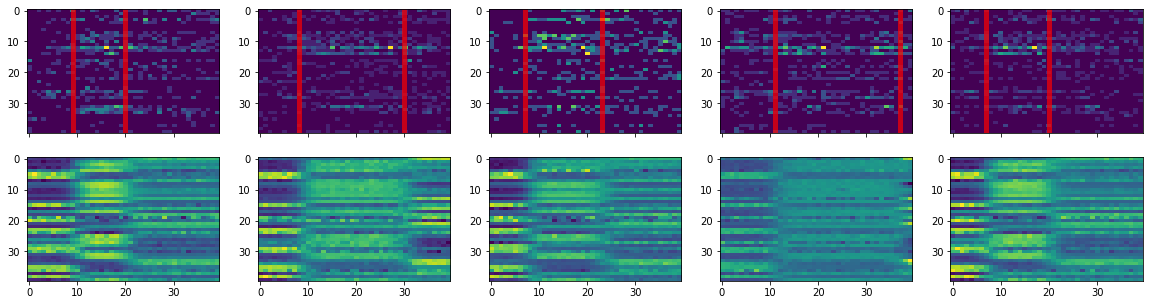

In [80]:
fig, ax = plt.subplots(2,trial_count,figsize = (20,5),sharex=True)
for trial_num, trial in enumerate(selected_trials):
    ax[0,trial_num].vlines(mode_tau[trial],-0.5,neurons-0.5, lw = 5, color='red',alpha = 0.7)
    ax[0,trial_num].imshow(data_vec_binned[trial],cmap='viridis',aspect='auto')
    ax[1,trial_num].imshow(stats.zscore(mean_ppc_obs[trial],axis=-1),cmap='viridis',aspect='auto')

Text(0.5, 1.0, 'Mean value of each W')

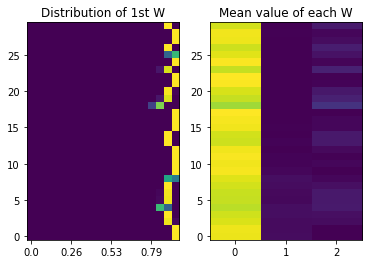

In [81]:
fig,ax = plt.subplots(1,2)
#ax[0].errorbar(x = mean_w[:,0], y = np.arange(trials), xerr = std_w[:,0], label='Inferred')
ax[0].imshow(w_hists,aspect='auto',origin='lower')
ax[0].set_xticks(np.arange(len(hist_bins))[::5])
ax[0].set_xticklabels(np.round(hist_bins[::5],2))
ax[0].set_title('Distribution of 1st W')
#ax[0].legend()
ax[1].imshow(mean_w,aspect='auto',origin='lower');
ax[1].set_title('Mean value of each W')